In [372]:
import pickle
import pickle
import torch
import torch.nn
import torch.optim
import torch.nn.functional
import numpy as np
import pandas
import spacy
import time
import random
import math

from torchtext import data
from torchtext.data import Field, BucketIterator

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

device = torch.device("cuda")

In [373]:
!pip install indic-nlp-library

In [374]:
from indicnlp.tokenize import indic_tokenize
data_1 = pandas.read_pickle("./en_hi.pkl")

train_data_temp, test_dataset = train_test_split(data_1, test_size = 0.2)
test_dataset.to_json('test_data.json', orient='records', lines=True)

train_dataset, validation_dataset = train_test_split(train_data_temp, test_size=0.125)
train_dataset.to_json('train_data.json', orient='records', lines=True)
validation_dataset.to_json('validation_data.json', orient='records', lines=True)

In [375]:
def hindi_tokenizer(sentence):
    ans = []
    for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip()):
        ans.append(word)
    print(ans)
    return ans

In [376]:
en_tokenizer = spacy.load('en')

def english_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]

In [377]:
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>')
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

In [378]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

# print(len(train_data), len(validation_data), len(test_data))

Streaming output truncated to the last 5000 lines.
['हम', 'आप', 'का', 'इलाज', 'कर', 'सकते', 'हैं', '.']
['तुम', 'क्या', 'कर', 'रहे', 'हो', '?']
['क्या', 'नहीं', ',', 'श्री', 'डुफ्रेन', '?']
['मुझे', 'आपके', 'ऊपर', 'विश्वास', 'है']
['एक', 'बार', 'में', 'ही', 'सबके', 'सब', 'उड़', 'जाएँगे', '।']
['हम', 'युवा', 'हैं', ',', 'खास', 'तौर', 'पर', 'जब', '.']
['मैं', 'करने', 'के', 'लिए', 'प्यार', 'होता', '.']
['ये', 'अभी', 'पके', 'नहीं', 'हैं', '।']
['उसे', 'पूरा', 'करने', 'के', 'लिए', 'चलते', 'हैं', '।']
['उसके', 'पास', 'कोई', 'अधिकार', 'नहीं', 'है', '.']
['वे', 'आर्थोपेडिक', 'जूते', 'की', 'तरह', 'लग', 'रही', 'है', '.']
['अपना', 'बैग', 'दिखाओ', 'मुझे', '!']
['.', '.', 'सेबों', 'के', 'भी', 'दील', '(', 'heart', ')', 'होता', 'है']
['अपने', 'नए', 'दोस्त', 'नहीं', 'है', '.']
['तुम्हें', 'किसकी', 'याद', 'ज़्यादा', 'आती', 'है', '?']
['मुझे', 'तुम्हारी', 'कोई', 'चिन्ता', 'नहीं', 'है', '.']
['मैं', 'उन्हें', 'बचाने', 'के', 'लिए', 'कोशिश', 'कर', 'रहा', 'हूँ', '।']
['झम', 'बारिश', 'हो', 'रही', 'है', '.']


In [379]:
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)

print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 1845, Hindi: 2078


In [380]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size,  dropout):
        super().__init__()
        self.word_embedding = torch.nn.Embedding(input_size, embedding_size) 
        self.dropout = torch.nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.gru = torch.nn.GRU(embedding_size, hidden_size,bidirectional=True)
        self.linear = torch.nn.Linear(2 * hidden_size, hidden_size)
        
    def forward(self, input):
        embedding_1 = self.dropout(self.word_embedding(input)) 
        out, h = self.gru(embedding_1) 
        h = torch.tanh(self.linear(torch.cat((h[-2,:,:], h[-1,:,:]), dim = 1)))

        return out, h

In [381]:
class Attention(torch.nn.Module):
    def __init__(self, enc_hid_size, dec_hid_size):
        super().__init__()
        self.attention = torch.nn.Linear((enc_hid_size * 2) + dec_hid_size, dec_hid_size)
        self.v = torch.nn.Linear(dec_hid_size, 1, bias = False)
        
    def forward(self, hidden, encoder_output_1):

        batch_size = encoder_output_1.shape[1]
        src_len = encoder_output_1.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_output_1 = encoder_output_1.permute(1, 0, 2)
        
        energy = torch.tanh(self.attention(torch.cat((hidden, encoder_output_1), dim = 2))) 

        attention = self.v(energy).squeeze(2)

        return torch.nn.functional.softmax(attention, dim=1)

In [382]:
class Decoder(torch.nn.Module):
    def __init__(self, output_size, emb_size, enc_hid_size, dec_hid_size, dropout, attention):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.rnn = torch.nn.GRU((enc_hid_size * 2) + emb_size, dec_hid_size)
        self.embedding = torch.nn.Embedding(output_size, emb_size)
        self.attention = attention
        self.output_size = output_size
        self.fc_out = torch.nn.Linear((enc_hid_size * 2) + dec_hid_size + emb_size, output_size)
        
    def forward(self, input, hidden, encoder_output_1):
        a = self.attention(hidden, encoder_output_1)
        a = a.unsqueeze(1)
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        encoder_output_1 = encoder_output_1.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_output_1)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

In [383]:
 class Model(torch.nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.decoder = decoder
        self.encoder = encoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_output_1, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_output_1)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        return outputs

In [384]:
INPUT_SIZE = len(ENGLISH.vocab)
OUTPUT_SIZE = len(HINDI.vocab)
ENC_EMB_SIZE = 400
DEC_EMB_SIZE = 400
ENC_HID_SIZE = 512
DEC_HID_SIZE = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attention = Attention(ENC_HID_SIZE, DEC_HID_SIZE)
enc = Encoder(INPUT_SIZE, ENC_EMB_SIZE, ENC_HID_SIZE, ENC_DROPOUT)
dec = Decoder(OUTPUT_SIZE, DEC_EMB_SIZE, ENC_HID_SIZE, DEC_HID_SIZE, DEC_DROPOUT, attention)

model = Model(enc, dec, device).to(device)

In [385]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            torch.nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            torch.nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Model(
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(1424, 512)
    (embedding): Embedding(2078, 400)
    (attention): Attention(
      (attention): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc_out): Linear(in_features=1936, out_features=2078, bias=True)
  )
  (encoder): Encoder(
    (word_embedding): Embedding(1845, 400)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(400, 512, bidirectional=True)
    (linear): Linear(in_features=1024, out_features=512, bias=True)
  )
)

In [386]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

In [387]:
optimizer = torch.optim.Adam(model.parameters())


In [388]:
TRG_PAD_IDX = HINDI.vocab.stoi[HINDI.pad_token]

criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [389]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    l=len(iterator)
    for i, batch in enumerate(iterator):
        input = batch.english
        output = batch.hindi
        optimizer.zero_grad()
        
        predictions = model(input,output,0)
        output_dim = predictions.shape[-1]
        
        predictions = predictions[1:].view(-1, output_dim)
        output = output[1:].view(-1)

        loss = criterion(predictions,output)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    l=len(iterator)    
    return epoch_loss / l

In [390]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    l=len(iterator)
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input = batch.english
            output = batch.hindi
            predictions = model(input,output, 0)
            output_dim = predictions.shape[-1]
            
            predictions = predictions[1:].view(-1, output_dim)
            output = output[1:].view(-1)
            loss = criterion(predictions,output)

            epoch_loss += loss.item()
    l=len(iterator)
    return epoch_loss / l

In [391]:
min_valid_loss = 1000000000
no_of_epochs = 8
CLIP = 1
training_losses=[]
validation_losses=[]
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)

for epoch in range(no_of_epochs):
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 6s
	Train Loss: 5.061 | Train PPL: 157.786
	 Val. Loss: 4.397 |  Val. PPL:  81.174
Epoch: 02 | Time: 0m 5s
	Train Loss: 4.432 | Train PPL:  84.115
	 Val. Loss: 4.099 |  Val. PPL:  60.255
Epoch: 03 | Time: 0m 6s
	Train Loss: 4.107 | Train PPL:  60.756
	 Val. Loss: 3.861 |  Val. PPL:  47.516
Epoch: 04 | Time: 0m 5s
	Train Loss: 3.806 | Train PPL:  44.951
	 Val. Loss: 3.707 |  Val. PPL:  40.725
Epoch: 05 | Time: 0m 6s
	Train Loss: 3.519 | Train PPL:  33.760
	 Val. Loss: 3.574 |  Val. PPL:  35.654
Epoch: 06 | Time: 0m 5s
	Train Loss: 3.238 | Train PPL:  25.493
	 Val. Loss: 3.465 |  Val. PPL:  31.988
Epoch: 07 | Time: 0m 6s
	Train Loss: 2.944 | Train PPL:  18.984
	 Val. Loss: 3.408 |  Val. PPL:  30.200
Epoch: 08 | Time: 0m 6s
	Train Loss: 2.640 | Train PPL:  14.020
	 Val. Loss: 3.417 |  Val. PPL:  30.476


No handles with labels found to put in legend.


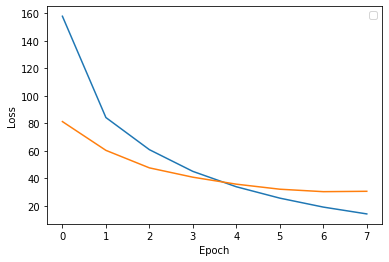

| Test Loss: 3.468 | Test PPL:  32.086 |


In [392]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.show()


model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [393]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaking native language:"))

['स्पाइडर', 'पुरुष', 'अपनी', 'अपनी', 'मातृभाषा', 'बोल', 'बोल']


In [394]:
import csv

translated_sentences = open('Paper2.csv','w')
csvwriter = csv.writer(translated_sentences)
csvwriter.writerow(['Input','Predicted','Actual'])  

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_dataset["english"], test_dataset["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

translated_sentences.close()